# Import modules

In [1]:
import os
import cv2
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as T
import torchvision.models as models

import albumentations as A

from albumentations.pytorch import ToTensorV2
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler
from matplotlib import pyplot as plt
from scripts import dataloader
from scripts.dataloader_albumentations import *

# Check hardware accelerator
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Define hyperparameters

In [2]:
NUM_CLASSES = 2
EPOCHS = 50
BATCH_SIZE = 16

# Load Dataset

In [3]:
# Set data paths
TRAIN_DIR = '/home/pytholic/Desktop/Projects/datasets/window_detection/data_final/data_splitted/train/'
VAL_DIR = '/home/pytholic/Desktop/Projects/datasets/window_detection/data_final/data_splitted/val/'
ref_paths = glob.glob('/home/pytholic/Desktop/Projects/datasets/window_detection/data_final/histogram_ref_images/*')

classes = os.listdir(TRAIN_DIR)
print("Total Classes: ",len(classes))

#Counting total train, & test images

train_count = 0
val_count = 0

for _class in classes:
    train_count += len(os.listdir(TRAIN_DIR + _class))
    val_count += len(os.listdir(VAL_DIR + _class))

print("Total train images: ", train_count)
print("Total test images: ", val_count)

Total Classes:  2
Total train images:  9072
Total test images:  789


In [4]:
def get_train_transform():
    resize = A.Resize(224, 224)
    normalize = A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    bright_contrast = A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.2)
    rgb_shift = A.RGBShift(p=0.05)
    hue_sat = A.HueSaturationValue(p=0.05)
    channel_shuffle = A.ChannelShuffle(p=0.05)
    gamma = A.RandomGamma(p=0.05)
    gray = A.ToGray(p=0.05)
    jitter = A.ColorJitter(p=0.05)
    hor_flip = A.HorizontalFlip(p=0.1)
    histogram = A.HistogramMatching(reference_images = ref_paths, p=1.0)
    rotate = A.Rotate(limit=15, p=0.1)
    crop = A.RandomCrop(height=100, width=100, p=0.1)
    translate = A.Affine(translate_percent=0.1, p=0.1)
    shear = A.Affine(shear=20, p=0.05)
    scale = A.Affine(scale=1.2, p=0.1)
    to_tensor = ToTensorV2()
    return A.Compose([resize, normalize, to_tensor])
#     return A.Compose([histogram, resize, normalize, rgb_shift, hue_sat, jitter, gray, bright_contrast, 
#                       hor_flip, rotate, translate, shear, scale, to_tensor])

def get_val_transform():
    resize = A.Resize(224, 224)
    normalize = A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    to_tensor = ToTensorV2()
    return A.Compose([resize, normalize, to_tensor])

In [5]:
train_dataset = CustomDataset(TRAIN_DIR, transforms=get_train_transform())
val_dataset = CustomDataset(VAL_DIR, transforms=get_val_transform())

print(len(train_dataset))
print(len(val_dataset))

9072
789


In [6]:
print(train_dataset[0][0].shape)
print(train_dataset[0][0])

torch.Size([3, 224, 224])
tensor([[[ 0.1059,  0.0980,  0.0980,  ..., -0.0039, -0.0353,  0.0431],
         [ 0.0902,  0.0824,  0.0824,  ..., -0.2235, -0.1216, -0.0118],
         [ 0.0824,  0.0824,  0.0824,  ..., -0.2157, -0.0118, -0.0902],
         ...,
         [ 0.9137,  0.9216,  0.8902,  ...,  0.2157,  0.0902,  0.1608],
         [ 0.9294,  0.9137,  0.9216,  ...,  0.1608,  0.1686,  0.1608],
         [ 0.9451,  0.9294,  0.9294,  ...,  0.1529,  0.1608,  0.1608]],

        [[ 0.0118,  0.0039,  0.0039,  ..., -0.2706, -0.2941, -0.1922],
         [ 0.0039,  0.0039,  0.0039,  ..., -0.3255, -0.2627, -0.1922],
         [ 0.0118,  0.0118,  0.0118,  ..., -0.3569, -0.2157, -0.3412],
         ...,
         [ 0.9059,  0.9137,  0.8824,  ...,  0.1216,  0.0196,  0.0902],
         [ 0.9216,  0.9059,  0.9137,  ...,  0.0667,  0.0824,  0.0745],
         [ 0.9451,  0.9294,  0.9216,  ...,  0.0510,  0.0510,  0.0275]],

        [[ 0.0118,  0.0039,  0.0039,  ..., -0.2235, -0.2549, -0.1529],
         [ 0.0039, 

In [7]:
print(train_dataset[0][0].min())
print(train_dataset[0][0].max())

tensor(-0.7412)
tensor(1.)


In [8]:
train_data_loader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle=True)
val_data_loader = DataLoader(dataset = val_dataset, batch_size = BATCH_SIZE, shuffle=False)

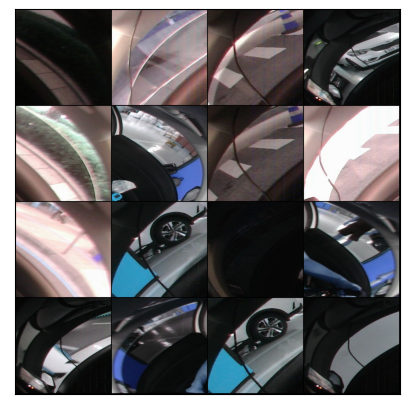

In [9]:
# Visualize one training batch
for images, labels in train_data_loader:
    fig, ax = plt.subplots(figsize = (5, 5))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4, normalize=True).permute(1,2,0), cmap='gray')
    break

# Training Pipeline

In [10]:
def set_device():
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev = "cpu"
    return torch.device(dev)

device = set_device()
print(device)

cuda:0


## Training functions

In [11]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    device = set_device()
    train_loss = []
    train_acc = []

    for epoch in range(num_epochs):
        #top1 = AverageMeter()
        print("Epoch number {}".format(epoch + 1))
        start = time.time()
        model.train()
        running_loss = 0.0
        running_correct = 0
        total = 0
      
        # Training
        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            #Reset Grads
            optimizer.zero_grad()

            #Forward ->
            outputs = model(images)

            # pred
            _, predicted = torch.max(outputs.data, 1)

            #Calculate Loss & Backward, Update Weights (Step)
            running_correct += (predicted == labels).sum().item()
            
            loss = criterion(outputs, labels)
            #loss = criterion(outputs.squeeze(), labels.unsqueeze(1).float())
            loss.backward()
            optimizer.step()

            running_loss += loss.item() 
            #acc = accuracy(outputs, labels)
            #top1.update(acc.item(), labels.size(0))
            
    
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100.00 * running_correct / total

        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
        
        #print(f"Accuracy: {top1.avg}")
        
        print("  - Training dataset: Got %d out of %d images correctly (%.3f%%). \nEpoch loss: %.3f"
            % (running_correct, total, epoch_acc, epoch_loss))

        val_acc = evaluate_model(model, val_loader)

        end = time.time()

        print("-  Epoch Time : {} \n".format(int(end-start)))

    print('Finished')
    return model, train_acc, train_loss, val_acc

In [12]:
# Validation function
def evaluate_model(model, val_loader):
    model.eval()
    predicted_correctly_on_epoch = 0
    total = 0
    best_acc = 0.0
    acc = []
    device = set_device()

    with torch.no_grad():
        for data in val_loader: 
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            predicted_correctly_on_epoch += (predicted == labels).sum().item()

    epoch_acc = 100.0 * predicted_correctly_on_epoch / total
    acc.append(epoch_acc)

    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), './model/model_new/best_model.pth')

    print("  - Testing dataset: Got %d out of %d images correctly (%.3f%%)"
        % (predicted_correctly_on_epoch, total, epoch_acc))

    return acc

## Model architecture

In [13]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
model.classifier = nn.Linear(1024, NUM_CLASSES)

Using cache found in /home/pytholic/.cache/torch/hub/pytorch_vision_v0.10.0
/home/pytholic/anaconda3/envs/window_detection/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/pytholic/anaconda3/envs/window_detection/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
model.to(device)
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## Training

In [15]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [16]:
model_trained, TRAIN_LOSS, TRAIN_ACC, VAL_ACC = train_model(model, train_data_loader, val_data_loader, criterion, optimizer, lr_scheduler, num_epochs=EPOCHS)

Epoch number 1
  - Training dataset: Got 7676 out of 9072 images correctly (84.612%). 
Epoch loss: 0.367
  - Testing dataset: Got 714 out of 789 images correctly (90.494%)
-  Epoch Time : 106 

Epoch number 2
  - Training dataset: Got 8269 out of 9072 images correctly (91.149%). 
Epoch loss: 0.225
  - Testing dataset: Got 726 out of 789 images correctly (92.015%)
-  Epoch Time : 104 

Epoch number 3
  - Training dataset: Got 8442 out of 9072 images correctly (93.056%). 
Epoch loss: 0.176
  - Testing dataset: Got 745 out of 789 images correctly (94.423%)
-  Epoch Time : 104 

Epoch number 4
  - Training dataset: Got 8579 out of 9072 images correctly (94.566%). 
Epoch loss: 0.151
  - Testing dataset: Got 753 out of 789 images correctly (95.437%)
-  Epoch Time : 105 

Epoch number 5
  - Training dataset: Got 8666 out of 9072 images correctly (95.525%). 
Epoch loss: 0.117
  - Testing dataset: Got 752 out of 789 images correctly (95.311%)
-  Epoch Time : 105 

Epoch number 6
  - Training da

  - Testing dataset: Got 779 out of 789 images correctly (98.733%)
-  Epoch Time : 98 

Epoch number 44
  - Training dataset: Got 9001 out of 9072 images correctly (99.217%). 
Epoch loss: 0.023
  - Testing dataset: Got 783 out of 789 images correctly (99.240%)
-  Epoch Time : 109 

Epoch number 45
  - Training dataset: Got 9011 out of 9072 images correctly (99.328%). 
Epoch loss: 0.020
  - Testing dataset: Got 774 out of 789 images correctly (98.099%)
-  Epoch Time : 107 

Epoch number 46
  - Training dataset: Got 9038 out of 9072 images correctly (99.625%). 
Epoch loss: 0.012
  - Testing dataset: Got 781 out of 789 images correctly (98.986%)
-  Epoch Time : 99 

Epoch number 47
  - Training dataset: Got 9051 out of 9072 images correctly (99.769%). 
Epoch loss: 0.006
  - Testing dataset: Got 777 out of 789 images correctly (98.479%)
-  Epoch Time : 100 

Epoch number 48
  - Training dataset: Got 9011 out of 9072 images correctly (99.328%). 
Epoch loss: 0.023
  - Testing dataset: Got 77